
# G15 - Saurabh Bhan / 1537
# Stock Prediction using Market Sentiment
### Analysing Twitter Sentiment regarding a particular stock to see if the market sentiment has any affect on the stock prices and using that to predict the stock price

[Stock dashboard](https://stocksage.herokuapp.com)

the above dahboard tells if the day ahead is Bullish or Bearish

#### Importing all the required libraries

In [ ]:
import pandas as pd 
import numpy as np
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats as stat
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

## Importing the Raw Twitter Data feed for the BankNifty

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project/tweets_refined.csv', error_bad_lines=False)

In [ ]:
df.head(5)

,date,time,tweet
0,2021-03-06,12:32:53,"SBIN forming head and shoulder pattern, ready ..."
1,2021-03-06,12:23:43,Banknifty 37300 க்கு போகிறதா? அல்லது 33300 க்க...
2,2021-03-06,12:20:45,@Nithin0dha @nikhilgupta_nkg Zerodha is on r8 ...
3,2021-03-06,12:20:24,@Sanju_Lakshya I know.. Reliance at 2500! Maru...
4,2021-03-06,12:16:36,#nifty50 #NIFTY #optiontrading #banknifty #bnf...


In [ ]:
df2= df.copy()

In [ ]:
df2 = df2[['date','time','tweet']]

In [ ]:
sentiment = SentimentIntensityAnalyzer()

## Cleaning Tweets


*   Removing any Symbol and unwanted words
*   Remove Special Characters except for #



In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.chararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

In [ ]:
df2['tweet'] = clean_tweets(df2['tweet'])

# Assigning Sentiment Score to Each tweet
each tweet has 4 sentiment score


*   Compound
*   Positive
*   Negative
*   Neutral



In [ ]:
scores = []
data = df2
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(data['tweet'].shape[0]):
    compound = sentiment.polarity_scores(data['tweet'][i])["compound"]
    pos = sentiment.polarity_scores(data['tweet'][i])["pos"]
    neu = sentiment.polarity_scores(data['tweet'][i])["neu"]
    neg = sentiment.polarity_scores(data['tweet'][i])["neg"]
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu
                  })

In [ ]:
sentiments_score = pd.DataFrame.from_dict(scores)
df2 = df2.join(sentiments_score)
df2.head()

,date,time,tweet,Compound,Positive,Negative,Neutral
0,2021-03-06,12:32:53,"SBIN forming head and shoulder pattern, ready ...",0.4199,0.083,0.000,0.917
1,2021-03-06,12:23:43,Banknifty 37300 க்கு போகிறதா? அல்லது 33300 க்க...,-0.5040,0.000,0.098,0.902
2,2021-03-06,12:20:45,Zerodha is on r8 track. Weekday it has glitc...,-0.4767,0.096,0.176,0.728
3,2021-03-06,12:20:24,I know.. Reliance at 2500! Maruti 98000... Ni...,0.6900,0.341,0.000,0.659
4,2021-03-06,12:16:36,#nifty50 #NIFTY #optiontrading #banknifty #bnf...,-0.3987,0.000,0.161,0.839


In [ ]:
## Save Cleaned Tweets and Score to CSV for faster retrieval
df2.to_csv('/content/drive/MyDrive/Project/tweets_refined_with_Score.csv', index=False)

In [ ]:
df2.shape

(310738, 7)

In [ ]:
df2['comp_score'] = df2['Compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

In [ ]:
df2['comp_score'].value_counts()

pos    277958
neg     32780
Name: comp_score, dtype: int64

In [ ]:
df2.head()

,date,time,tweet,Compound,Positive,Negative,Neutral,comp_score
0,2021-03-06,12:32:53,"SBIN forming head and shoulder pattern, ready ...",0.4199,0.083,0.000,0.917,pos
1,2021-03-06,12:23:43,Banknifty 37300 க்கு போகிறதா? அல்லது 33300 க்க...,-0.5040,0.000,0.098,0.902,neg
2,2021-03-06,12:20:45,Zerodha is on r8 track. Weekday it has glitc...,-0.4767,0.096,0.176,0.728,neg
3,2021-03-06,12:20:24,I know.. Reliance at 2500! Maruti 98000... Ni...,0.6900,0.341,0.000,0.659,pos
4,2021-03-06,12:16:36,#nifty50 #NIFTY #optiontrading #banknifty #bnf...,-0.3987,0.000,0.161,0.839,neg


# Combining the Date and Time column 
Resampling the data on the datetime column on daily basis with mean

In [ ]:
df2['dt']= pd.to_datetime(df2['date'] + ' ' + df2['time'])

In [ ]:
df2 = df2.resample('D', on='dt').mean()

In [ ]:
df2.head()

,Compound,Positive,Negative,Neutral
dt,,,,
2020-01-12,0.338257,0.150236,0.016870,0.832911
2020-01-13,0.292849,0.136492,0.023502,0.840002
2020-01-14,0.276419,0.128667,0.027217,0.844126
2020-01-15,0.264436,0.134513,0.026938,0.838545
2020-01-16,0.259652,0.128046,0.030825,0.839420


In [ ]:
df2['dt'] = df2.index

In [ ]:
df2.head()

,Compound,Positive,Negative,Neutral,dt
dt,,,,,
2020-01-12,0.338257,0.150236,0.016870,0.832911,2020-01-12
2020-01-13,0.292849,0.136492,0.023502,0.840002,2020-01-13
2020-01-14,0.276419,0.128667,0.027217,0.844126,2020-01-14
2020-01-15,0.264436,0.134513,0.026938,0.838545,2020-01-15
2020-01-16,0.259652,0.128046,0.030825,0.839420,2020-01-16


In [ ]:
df2.shape

(420, 5)

In [ ]:
df2.isnull().sum()

Compound    16
Positive    16
Negative    16
Neutral     16
dt           0
dtype: int64

In [ ]:
df2.dropna(inplace=True)

# Plotting all the values for Sentiment Score

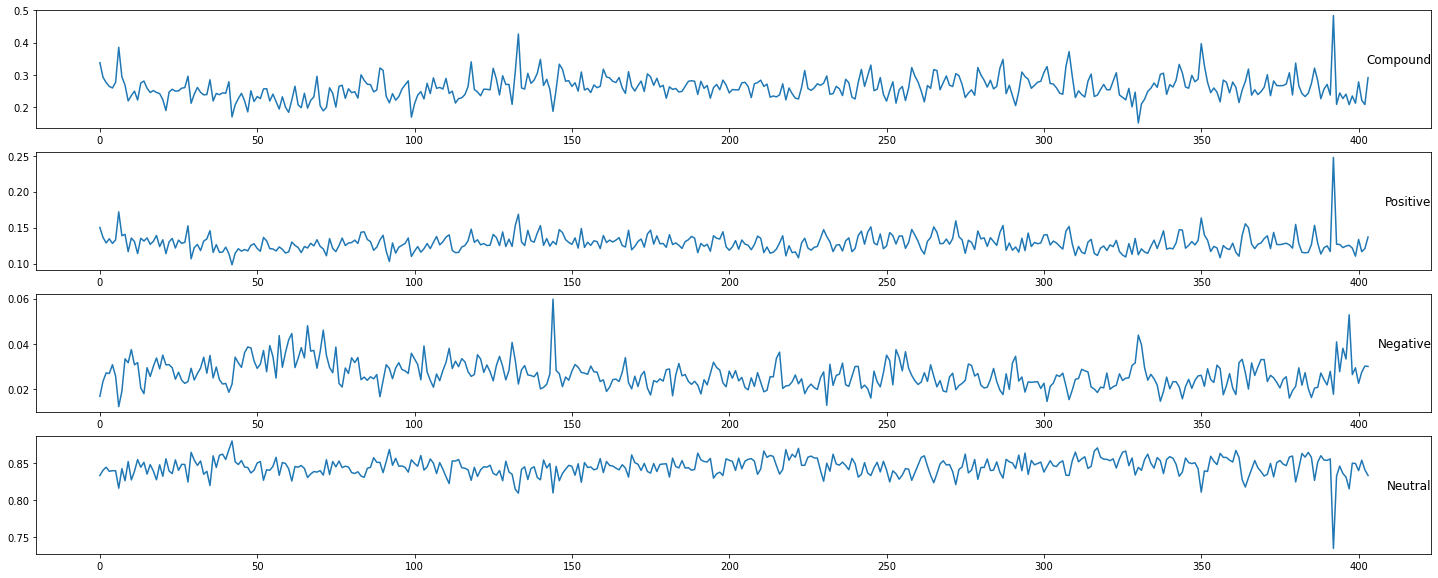

In [ ]:
values = df2.values
# specify columns to plot
groups = [ 0,1,2,3]
i = 1
# plot each column
plt.figure(figsize=(25,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df2.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

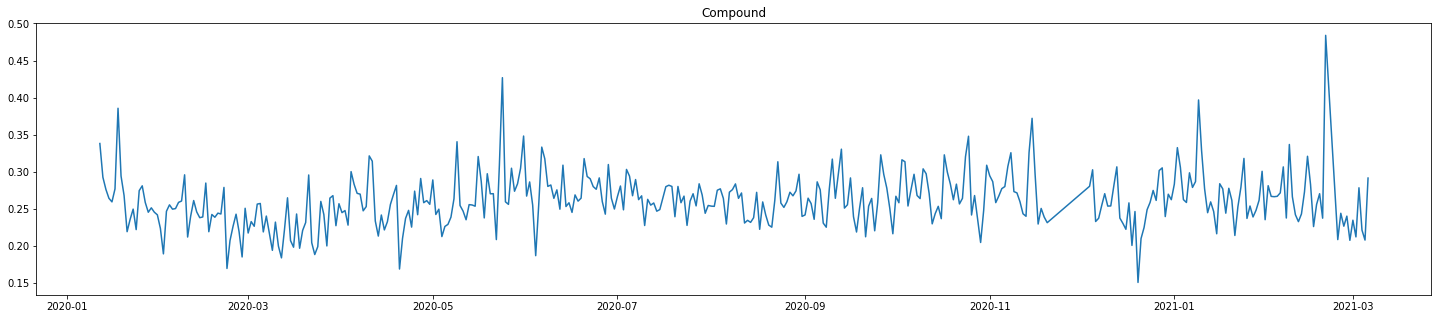

In [ ]:
x = df2['dt']
y = df2['Compound']
plt.figure(figsize=(25,5))
plt.title("Compound", loc='center')
plt.plot(x,y)
plt.show()

# Importing Stock Data from yfinance

> Using Yfinance to pull the historical Stock data



In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 11.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=1b1adf941bb57c9f5347f95dc63eecdea22a278959e5e54ff81bd17a0afb1797
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# ^NSEBANK is the ticker for BankNifty in the NSE

In [ ]:
import yfinance as yf
ts = yf.Ticker("^NSEBANK")

In [ ]:
hist = ts.history(period="max")
print(hist)

                    Open          High  ...  Dividends  Stock Splits
Date                                    ...                         
2007-09-17   6898.000000   6977.200195  ...          0             0
2007-09-18   6921.149902   7078.950195  ...          0             0
2007-09-19   7111.000000   7419.350098  ...          0             0
2007-09-20   7404.950195   7462.899902  ...          0             0
2007-09-21   7378.299805   7506.350098  ...          0             0
...                  ...           ...  ...        ...           ...
2021-03-22  34088.398438  34148.898438  ...          0             0
2021-03-23  33747.949219  34360.050781  ...          0             0
2021-03-24  33894.699219  33970.648438  ...          0             0
2021-03-25  33420.750000  33550.148438  ...          0             0
2021-03-26  33605.050781  33610.648438  ...          0             0

[3035 rows x 7 columns]


# Plotting the Stock data

In [ ]:
hist = hist.reset_index()
for i in ['Open', 'High', 'Close', 'Low']: 
      hist[i]  =  hist[i].astype('float64')
# show actions (dividends, splits)
ts.actions
import plotly.graph_objects as go
fig = go.Figure(data=go.Ohlc(x=hist['Date'],
                    open=hist['Open'],
                    high=hist['High'],
                    low=hist['Low'],
                    close=hist['Close']))
fig.show()

In [ ]:
#  getting hourly data from yfinance
hist_hour = ts.history(interval='1D', start="2020-01-12", end='2021-03-24')
print(hist_hour)

                    Open          High  ...  Dividends  Stock Splits
Date                                    ...                         
2020-01-13  32139.099609  32322.650391  ...          0             0
2020-01-14  32196.449219  32196.449219  ...          0             0
2020-01-15  31994.750000  32000.900391  ...          0             0
2020-01-16  31810.550781  31988.900391  ...          0             0
2020-01-17  31571.650391  31773.550781  ...          0             0
...                  ...           ...  ...        ...           ...
2021-03-17  34905.050781  35100.500000  ...          0             0
2021-03-18  34577.500000  34759.851562  ...          0             0
2021-03-19  33590.398438  34355.398438  ...          0             0
2021-03-22  34088.398438  34148.898438  ...          0             0
2021-03-23  33747.949219  34360.050781  ...          0             0

[297 rows x 7 columns]


In [ ]:
hist_hour = hist_hour.reset_index()
for i in ['Open', 'High', 'Close', 'Low']: 
      hist_hour[i]  =  hist_hour[i].astype('float64')
# show actions (dividends, splits)
ts.actions
import plotly.graph_objects as go
fig = go.Figure(data=go.Ohlc(x=hist_hour['Date'],
                    open=hist_hour['Open'],
                    high=hist_hour['High'],
                    low=hist_hour['Low'],
                    close=hist_hour['Close']))
fig.show()

# Plotting the correlation between the stock and the twitter sentiment

In [ ]:
def sentiment_overtime(tweets,stock,title):
    visual= tweets.Compound.rolling(30).mean().dropna()
    corr_test = tweets.Compound.dropna()
    corr, pval = stat.spearmanr(corr_test.reindex(stock.Date), stock['Close'],nan_policy='omit')
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot()
    ax2 = fig.add_subplot()
    ax2 = ax1.twinx()
    
    ax1.plot(visual.index,visual,label='Tweets Sentiment')
    ax2.plot(stock.Date,stock.Close,color='orange',label='share price')
    ax2.set_title(f'Effect of Tweet Sentiment of {title} over time on share price of  {title} {corr} {pval}')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



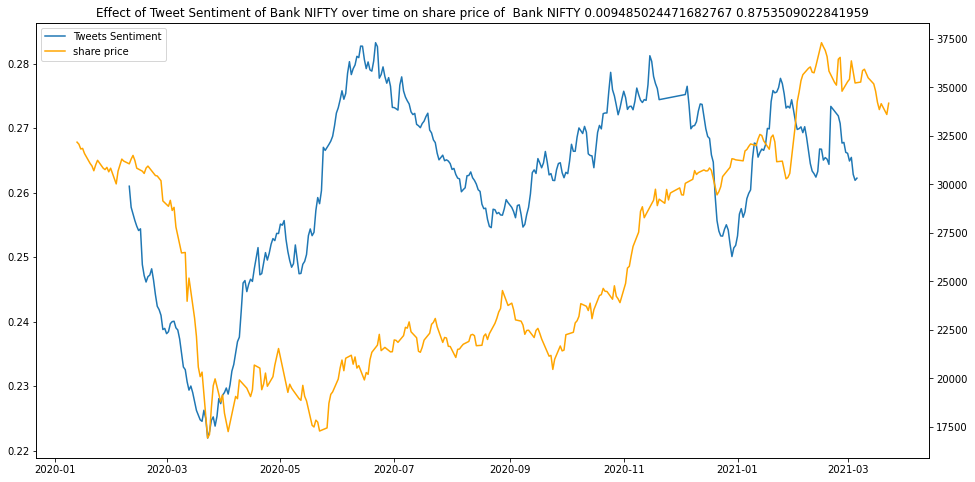

In [ ]:
sentiment_overtime(df2,hist_hour,"Bank NIFTY")

In [ ]:
df3 = df2.copy()

In [ ]:
df3.head()

,Compound,Positive,Negative,Neutral,dt
dt,,,,,
2020-01-12,0.338257,0.150236,0.016870,0.832911,2020-01-12
2020-01-13,0.292849,0.136492,0.023502,0.840002,2020-01-13
2020-01-14,0.276419,0.128667,0.027217,0.844126,2020-01-14
2020-01-15,0.264436,0.134513,0.026938,0.838545,2020-01-15
2020-01-16,0.259652,0.128046,0.030825,0.839420,2020-01-16


In [ ]:
df3 = df3.drop('dt', 1)


In [ ]:
hist_hour.index = hist_hour.Date

## Merging Both the twitter and stock dataframe to feed it into the ML models

In [ ]:
df3 = pd.merge(df3, hist_hour, how='outer', left_index=True, right_index=True)

In [ ]:
df3

,Compound,Positive,Negative,Neutral,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
2020-01-12,0.338257,0.150236,0.016870,0.832911,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-13,0.292849,0.136492,0.023502,0.840002,2020-01-13,32139.099609,32322.650391,32074.050781,32177.650391,291400.0,0.0,0.0
2020-01-14,0.276419,0.128667,0.027217,0.844126,2020-01-14,32196.449219,32196.449219,31989.199219,32071.650391,438900.0,0.0,0.0
2020-01-15,0.264436,0.134513,0.026938,0.838545,2020-01-15,31994.750000,32000.900391,31670.349609,31824.900391,545700.0,0.0,0.0
2020-01-16,0.259652,0.128046,0.030825,0.839420,2020-01-16,31810.550781,31988.900391,31692.400391,31853.900391,253700.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17,NaN,NaN,NaN,NaN,2021-03-17,34905.050781,35100.500000,34126.851562,34229.250000,0.0,0.0,0.0
2021-03-18,NaN,NaN,NaN,NaN,2021-03-18,34577.500000,34759.851562,33597.550781,33856.800781,0.0,0.0,0.0
2021-03-19,NaN,NaN,NaN,NaN,2021-03-19,33590.398438,34355.398438,33361.000000,34161.601562,0.0,0.0,0.0
2021-03-22,NaN,NaN,NaN,NaN,2021-03-22,34088.398438,34148.898438,33389.148438,33603.449219,0.0,0.0,0.0


In [ ]:
df3 = df3.drop(['Date','Open','High','Low','Volume','Dividends','Stock Splits'], 1)


In [ ]:
df3

,Compound,Positive,Negative,Neutral,Close
2020-01-12,0.338257,0.150236,0.016870,0.832911,NaN
2020-01-13,0.292849,0.136492,0.023502,0.840002,32177.650391
2020-01-14,0.276419,0.128667,0.027217,0.844126,32071.650391
2020-01-15,0.264436,0.134513,0.026938,0.838545,31824.900391
2020-01-16,0.259652,0.128046,0.030825,0.839420,31853.900391
...,...,...,...,...,...
2021-03-17,NaN,NaN,NaN,NaN,34229.250000
2021-03-18,NaN,NaN,NaN,NaN,33856.800781
2021-03-19,NaN,NaN,NaN,NaN,34161.601562
2021-03-22,NaN,NaN,NaN,NaN,33603.449219


In [ ]:
df3['Close'] = df3['Close'].ffill()

In [ ]:
df3['Close'] = df3['Close'].bfill()

In [ ]:
df3

,Compound,Positive,Negative,Neutral,Close
2020-01-12,0.338257,0.150236,0.016870,0.832911,32177.650391
2020-01-13,0.292849,0.136492,0.023502,0.840002,32177.650391
2020-01-14,0.276419,0.128667,0.027217,0.844126,32071.650391
2020-01-15,0.264436,0.134513,0.026938,0.838545,31824.900391
2020-01-16,0.259652,0.128046,0.030825,0.839420,31853.900391
...,...,...,...,...,...
2021-03-17,NaN,NaN,NaN,NaN,34229.250000
2021-03-18,NaN,NaN,NaN,NaN,33856.800781
2021-03-19,NaN,NaN,NaN,NaN,34161.601562
2021-03-22,NaN,NaN,NaN,NaN,33603.449219


# LSTM (Long Short Term Memory )
using the lstm to predict the stock price with multiple feature as the twitter sentiment

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df3.values)

In [ ]:
scaled

array([[0.56227473, 0.34768175, 0.09575543, 0.67882727, 0.74845749],
       [0.42583678, 0.25570732, 0.23552685, 0.72776166, 0.74845749],
       [0.37646988, 0.20334306, 0.31382091, 0.75621642, 0.7432585 ],
       ...,
       [       nan,        nan,        nan,        nan, 0.84576437],
       [       nan,        nan,        nan,        nan, 0.81838867],
       [       nan,        nan,        nan,        nan, 0.84688249]])

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
n_hours = 3
n_features = 5
n_obs = n_hours*n_features

In [ ]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.562275,0.347682,0.095755,0.678827,0.748457,0.425837,0.255707,0.235527,0.727762,0.748457,0.376470,0.203343,0.313821,0.756216,0.743259,0.340464,0.242467,0.307930,0.717709,0.731156
4,0.425837,0.255707,0.235527,0.727762,0.748457,0.376470,0.203343,0.313821,0.756216,0.743259,0.340464,0.242467,0.307930,0.717709,0.731156,0.326088,0.199192,0.389857,0.723747,0.732579
5,0.376470,0.203343,0.313821,0.756216,0.743259,0.340464,0.242467,0.307930,0.717709,0.731156,0.326088,0.199192,0.389857,0.723747,0.732579,0.378515,0.231839,0.284338,0.722838,0.719667
6,0.340464,0.242467,0.307930,0.717709,0.731156,0.326088,0.199192,0.389857,0.723747,0.732579,0.378515,0.231839,0.284338,0.722838,0.719667,0.704941,0.492868,0.000000,0.560394,0.719667
7,0.326088,0.199192,0.389857,0.723747,0.732579,0.378515,0.231839,0.284338,0.722838,0.719667,0.704941,0.492868,0.000000,0.560394,0.719667,0.430593,0.270876,0.142896,0.742711,0.719667


In [ ]:
reframed = reframed.drop(reframed.columns[-4:], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
3,0.562275,0.347682,0.095755,0.678827,0.748457,0.425837,0.255707,0.235527,0.727762,0.748457,0.376470,0.203343,0.313821,0.756216,0.743259,0.340464
4,0.425837,0.255707,0.235527,0.727762,0.748457,0.376470,0.203343,0.313821,0.756216,0.743259,0.340464,0.242467,0.307930,0.717709,0.731156,0.326088
5,0.376470,0.203343,0.313821,0.756216,0.743259,0.340464,0.242467,0.307930,0.717709,0.731156,0.326088,0.199192,0.389857,0.723747,0.732579,0.378515
6,0.340464,0.242467,0.307930,0.717709,0.731156,0.326088,0.199192,0.389857,0.723747,0.732579,0.378515,0.231839,0.284338,0.722838,0.719667,0.704941
7,0.326088,0.199192,0.389857,0.723747,0.732579,0.378515,0.231839,0.284338,0.722838,0.719667,0.704941,0.492868,0.000000,0.560394,0.719667,0.430593


In [ ]:
reframed.shape

(395, 16)

In [ ]:
values = reframed.values
n_train_hours = 170
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(170, 16)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 3, 5) (170,) (225, 3, 5) (225,)


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [ ]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Epoch 1/20
43/43 - 3s - loss: 0.0772 - val_loss: 0.0764
Epoch 2/20
43/43 - 0s - loss: 0.0629 - val_loss: 0.0703
Epoch 3/20
43/43 - 0s - loss: 0.0587 - val_loss: 0.0636
Epoch 4/20
43/43 - 0s - loss: 0.0537 - val_loss: 0.0561
Epoch 5/20
43/43 - 0s - loss: 0.0483 - val_loss: 0.0503
Epoch 6/20
43/43 - 0s - loss: 0.0443 - val_loss: 0.0483
Epoch 7/20
43/43 - 0s - loss: 0.0426 - val_loss: 0.0442
Epoch 8/20
43/43 - 0s - loss: 0.0397 - val_loss: 0.0434
Epoch 9/20
43/43 - 0s - loss: 0.0380 - val_loss: 0.0399
Epoch 10/20
43/43 - 0s - loss: 0.0358 - val_loss: 0.0377
Epoch 11/20
43/43 - 0s - loss: 0.0339 - val_loss: 0.0359
Epoch 12/20
43/43 - 0s - loss: 0.0324 - val_loss: 0.0341
Epoch 13/20
43/43 - 0s - loss: 0.0309 - val_loss: 0.0327
Epoch 14/20
43/43 - 0s - loss: 0.0289 - val_loss: 0.0308
Epoch 15/20
43/43 - 0s - loss: 0.0275 - val_loss: 0.0294
Epoch 16/20
43/43 - 0s - loss: 0.0257 - val_loss: 0.0268
Epoch 17/20
43/43 - 0s - loss: 0.0245 - val_loss: 0.0247
Epoch 18/20
43/43 - 0s - loss: 0.0242 - 

In [ ]:
# # save the model to disk
# import joblib
# filename_lstm = 'finalized_model_LSTM.sav'
# joblib.dump(model, filename_lstm)

TypeError: ignored

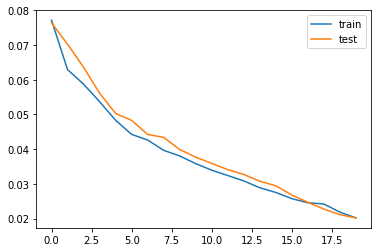

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Making the prediction and printing out RMSE

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.008


In [ ]:
print('R-squared :', metrics.r2_score(inv_y, inv_yhat))

R-squared : 0.8745886878914815


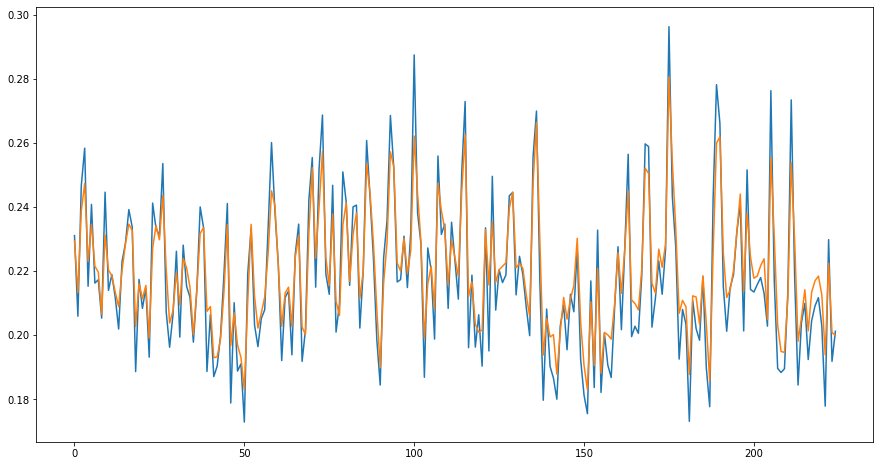

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(inv_y)
plt.plot(inv_yhat)

# **MAPE for LSTM**

In [ ]:
#MAPE(inv_y,inv_yhat)

# XGBoost


In [ ]:
df3

,Compound,Positive,Negative,Neutral,Close
2020-01-12,0.338257,0.150236,0.016870,0.832911,32177.650391
2020-01-13,0.292849,0.136492,0.023502,0.840002,32177.650391
2020-01-14,0.276419,0.128667,0.027217,0.844126,32071.650391
2020-01-15,0.264436,0.134513,0.026938,0.838545,31824.900391
2020-01-16,0.259652,0.128046,0.030825,0.839420,31853.900391
...,...,...,...,...,...
2021-03-17,NaN,NaN,NaN,NaN,34229.250000
2021-03-18,NaN,NaN,NaN,NaN,33856.800781
2021-03-19,NaN,NaN,NaN,NaN,34161.601562
2021-03-22,NaN,NaN,NaN,NaN,33603.449219


In [ ]:
# pct change based on Adj close value
df3["Pct_change"] = df3["Close"].pct_change()

In [ ]:
# Drop null values
df3.dropna(inplace = True)
df3.head()

,Compound,Positive,Negative,Neutral,Close,Pct_change
2020-01-13,0.292849,0.136492,0.023502,0.840002,32177.650391,0.000000
2020-01-14,0.276419,0.128667,0.027217,0.844126,32071.650391,-0.003294
2020-01-15,0.264436,0.134513,0.026938,0.838545,31824.900391,-0.007694
2020-01-16,0.259652,0.128046,0.030825,0.839420,31853.900391,0.000911
2020-01-17,0.277100,0.132925,0.025818,0.839289,31590.650391,-0.008264


In [ ]:
# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, target_col_number):
    # Create empty lists "X_close", "X_polarity" and y
    X_close = []
    X_polarity = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, ts_polarity, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_close.append(close)
        X_polarity.append(ts_polarity)
        y.append(target)
        
    return np.hstack((X_close,X_polarity)), np.array(y).reshape(-1, 1)

In [ ]:
# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

# Column index 4 is the `Close` column
# Column index 0 is the `Compound` column
feature_col_number1 = 4
feature_col_number2 = 0
target_col_number = 4
X, y = window_data(df3, window_size, feature_col_number1, feature_col_number2, target_col_number)

In [ ]:
# Use 70% of the data for training and 30% for testing
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

# Set X_train, X_test, y_train, t_test
X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [ ]:
# Create the XG Boost regressor instance
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [ ]:
# Fit the model
model.fit(X_train, y_train.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
# save the model to disk
import joblib
filename_xg = 'finalized_model_XGBoost.sav'
joblib.dump(model, filename_xg)

In [ ]:
# Make some predictions
predicted = model.predict(X_test)

In [ ]:
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.07228175150951836
R-squared : 0.9239116025926624


In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df3.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2020-10-22,24484.150391,25157.730469
2020-10-23,24478.300781,24912.093750
2020-10-24,24478.300781,24380.076172
2020-10-25,24478.300781,24508.367188
2020-10-26,24075.449219,24515.683594


In [ ]:
stocks.tail()

,Real,Predicted
2021-03-02,35419.699219,35531.527344
2021-03-03,36368.050781,35214.019531
2021-03-04,35802.500000,36127.554688
2021-03-05,35228.148438,35653.886719
2021-03-06,35228.148438,34832.718750


In [ ]:
#percentage_error(y_test,predicted)

# MAPE for XGBoost

In [ ]:
#mean_absolute_percentage_error(real_prices,predicted_prices)

In [ ]:
import seaborn as sns

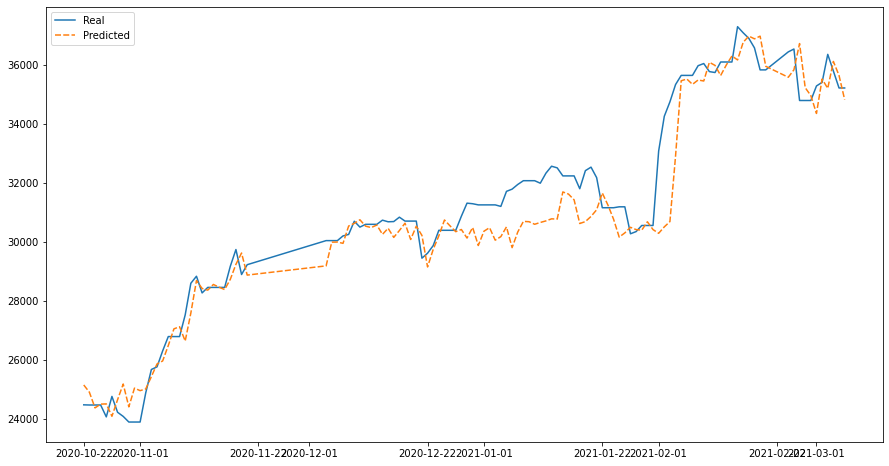

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=stocks)

In [ ]:
stocks.tail

<bound method NDFrame.tail of                     Real     Predicted
2020-10-22  24484.150391  25157.730469
2020-10-23  24478.300781  24912.093750
2020-10-24  24478.300781  24380.076172
2020-10-25  24478.300781  24508.367188
2020-10-26  24075.449219  24515.683594
...                  ...           ...
2021-03-02  35419.699219  35531.527344
2021-03-03  36368.050781  35214.019531
2021-03-04  35802.500000  36127.554688
2021-03-05  35228.148438  35653.886719
2021-03-06  35228.148438  34832.718750

[120 rows x 2 columns]>

# ARIMA
using ARIMA to predict the Stock Price

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
df = hist
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Testing Mean Squared Error is 183102.3513325277


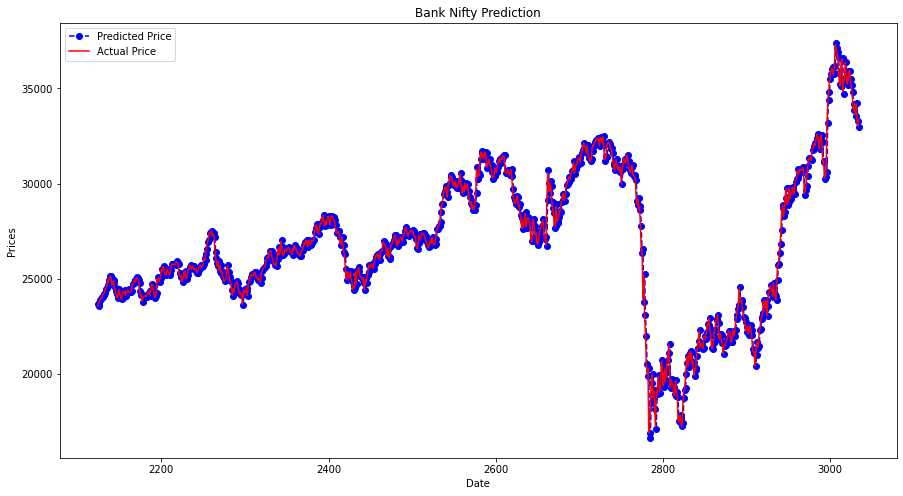

In [ ]:
test_set_range = df[int(len(df)*0.7):].index
plt.figure(figsize=(15,8))
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('Bank Nifty Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

# MAPE for ARIMA

In [ ]:
MAPE(test_data,model_predictions)

16.17041357355336

In [ ]:
s = hist_hour.Close.tail(30).tolist()

In [ ]:
model = ARIMA(s, order=(3,2,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast()

In [ ]:
output[0]

array([34199.960524])

In [ ]:
hist_hour[['Date','Close']]

,Date,Close
Date,,
2020-01-13,2020-01-13,32177.650391
2020-01-14,2020-01-14,32071.650391
2020-01-15,2020-01-15,31824.900391
2020-01-16,2020-01-16,31853.900391
2020-01-17,2020-01-17,31590.650391
...,...,...
2021-03-17,2021-03-17,34229.250000
2021-03-18,2021-03-18,33856.800781
2021-03-19,2021-03-19,34161.601562


In [ ]:
pred = []
days = 3
for i in range(days):
  model = ARIMA(s, order=(1,2,0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0].astype(float)
  s.append(yhat)
  pred.append(yhat[0])


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
s

[36056.5,
 35783.1015625,
 35752.1015625,
 36108.8984375,
 37306.25,
 37098.3984375,
 36910.94921875,
 36587.0,
 35841.6015625,
 35257.19921875,
 35116.94921875,
 36452.30078125,
 36549.0,
 34803.6015625,
 35296.0,
 35419.69921875,
 36368.05078125,
 35802.5,
 35228.1484375,
 35275.75,
 35865.6484375,
 35938.30078125,
 35496.6484375,
 35182.55078125,
 34804.6015625,
 34229.25,
 33856.80078125,
 34161.6015625,
 33603.44921875,
 34184.3984375,
 array([34407.75221712]),
 array([34775.87595936]),
 array([35119.96378032])]

In [ ]:
pred

In [ ]:
h = ts.history(interval='1D', start="2020-03-05", end='2021-03-24')

In [ ]:
h.Close.tail(15)

In [ ]:
model = ARIMA(h.Close.tail(15), order=(1,2,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
output[0]

array([34283.54121763])

In [ ]:
MSE_error = mean_squared_error(h.Close.tail(3), pred)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 770152.3725186335


In [ ]:
stocks2 = pd.DataFrame({
    "Real": h.Close.tail(3).ravel(),
    "Predicted": pred
}, index = h.index[-len(h.Close.tail(3)): ]) 
stocks2.head()

,Real,Predicted
Date,,
2021-03-19,34161.601562,34407.752217
2021-03-22,33603.449219,34775.875959
2021-03-23,34184.398438,35119.963780


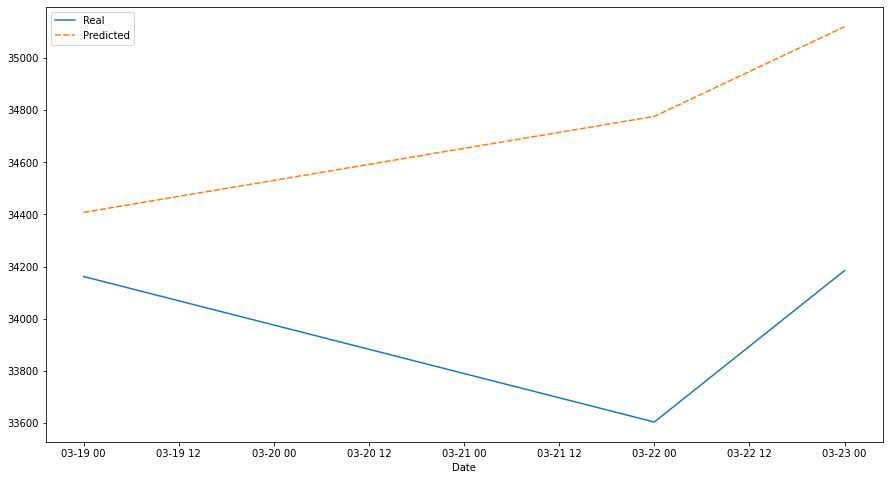

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.lineplot(data=stocks2)

In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
MAPE(h.Close.tail(3),pred)

2.315458190135793

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [ ]:
percentage_error(h.Close.tail(3),pred)

array([-0.00720548, -0.03489007, -0.0273682 ])

In [ ]:
mean_absolute_percentage_error(h.Close.tail(3),pred)

2.315458190135793

In [ ]:
print('MAPE for LSTM :    ' , MAPE(inv_y,inv_yhat))  
print('MAPE for ARIMA :   ', MAPE(test_data,model_predictions))
print('MAPE for XGBoost : ',mean_absolute_percentage_error(y_test,predicted))

MAPE for LSTM :     3.1293486097323844
MAPE for ARIMA :    16.17041357355336
MAPE for XGBoost :  18.626062613582974
